In [1]:
import torch
import sys
sys.path.append('../models/')
from alexnet import *
from densenet_201 import *
from mobilenet_v2 import *
from resnet_50 import *
from vgg_19 import *

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import norm
import tqdm
import torchattacks

In [3]:
def pltshow(img,gray=False):
    img = transforms.ToPILImage()(img)
    plt.figure(figsize=(2,2))
    plt.axis('off')
    if(gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)

In [4]:
# add border to image so that it can be divided perfectly with block_size
def addborder(img,block_size=8):
    diff_x = img.shape[0] % block_size
    diff_y = img.shape[1] % block_size
    if (diff_x==0 and diff_y==0):
        return img
    img = cv2.copyMakeBorder(img,
              0,(block_size-diff_x),
              0,(block_size-diff_y),
              cv2.BORDER_REPLICATE)
    return img

In [5]:
def block_dct(bk,block_size=8):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_dct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
# with tqdm(total=img_dct_blocks_h*img_dct_blocks_w) as pbar:
#     pbar.set_description('DCT Processing')
    for h in range(img_dct_blocks_h):
        for w in range(img_dct_blocks_w):
            a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
            img_dct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
            cv2.dct(a_block)
            # pbar.update(1)
    return torch.from_numpy(img_dct).cuda()

def block_idct(bk,block_size=8):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_idct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
# with tqdm(total=img_dct_blocks_h*img_dct_blocks_w) as pbar:
#     pbar.set_description('IDCT Processing')
    for h in range(img_dct_blocks_h):
        for w in range(img_dct_blocks_w):
            a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
            img_idct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
            cv2.idct(a_block)
            # pbar.update(1)
    return torch.from_numpy(img_idct).cuda()

def dct_tensor(img,block_size=8):
    img = img.cpu().numpy()
    if img.ndim == 2:
        return block_dct(img,block_size)
    elif img.shape[0] == 1:
        return block_dct(img[0,...],block_size)
    else:
        return torch.stack((block_dct(img[0,...],block_size),block_dct(img[1,...],block_size),block_dct(img[2,...],block_size)),dim=0)

def idct_tensor(img,block_size=8):
    img = img.cpu().numpy()
    if img.ndim == 2:
        return block_idct(img,block_size)
    elif img.shape[0] == 1:
        return block_idct(img[0,...],block_size)
    else:
        return torch.stack((block_idct(img[0,...],block_size),block_idct(img[1,...],block_size),block_idct(img[2,...],block_size)),dim=0)

def embed_wm(img,wm,alpha,block_size=8):
    img_dct = dct_tensor(img,block_size)
    img_dct_wm = img_dct + alpha*wm
    img_wm_idct = idct_tensor(img_dct_wm,block_size)
    wmed_img = img_wm_idct.clip(0,1)
    return wmed_img

def extract_wm(img,wmed_img,alpha,block_size=8):
    img_dct = dct_tensor(img,block_size)
    wmed_dct = dct_tensor(wmed_img,block_size)
    wm = (wmed_dct-img_dct)/alpha
    return wm

In [6]:
def check_out(model,img,target):
    img = torch.unsqueeze(img,0).type(torch.FloatTensor).cuda()
    out = (F.softmax(model(img),dim=1))
    out = out.argmax()
    return (out == target).item()

In [7]:
def alpha_update(alpha,beta,l1,l2,step,idct_wm,per,dct_per):
    grad = l1*norm(alpha*idct_wm+beta*per)*norm(idct_wm)-l2*(beta/alpha**2)*norm(dct_per)
    alpha_new = alpha - step*alpha
    if alpha_new < 0:
        alpha_new = alpha
    return alpha_new
def beta_update(alpha,beta,l1,l2,step,idct_wm,per,dct_per):
    grad = l1*norm(alpha*idct_wm+beta*per)*norm(per)+l2*(1/alpha)*norm(dct_per)
    beta_new = beta - step*beta
    if beta_new < 0:
        beta_new = beta
    return beta_new

In [8]:
def opti(img,wm,model,atk,target,N,alpha,beta,l1,l2,s_a,s_b):
    wmed_origin = embed_wm(img,wm,alpha)
    wmed_input = torch.unsqueeze(wmed_origin,0).type(torch.FloatTensor).cuda()
    adv_images = atk(wmed_input, target)
    adv_wmed_origin = adv_images[0,...]
    per = (adv_wmed_origin-wmed_origin)/beta
    per_dct = dct_tensor(per)
    wm_per = per_dct * (beta/alpha)
    wm_perturbed = (wm_per+wm).clip(0,1)
    wmed = embed_wm(img,wm_perturbed,alpha)
    idct_wm = idct_tensor(wm)
    dct_per = dct_tensor(per)
    wm_res = wm_perturbed
    wmed_res = wmed
    with tqdm(total=N) as pbar:
        pbar.set_description('Optimization Processing')
        for n in range(N):
            alpha_new = alpha_update(alpha,beta,l1,l2,s_a,idct_wm,per,dct_per)
            beta_new = beta_update(alpha,beta,l1,l2,s_b,idct_wm,per,dct_per)
            wm_perturbed = (wm + (beta_new/alpha_new)*dct_per).clip(0,1)
            wmed = embed_wm(img,wm_perturbed,alpha_new)
            if check_out(model,wmed,target):
                return wm_res,wmed_res
            else:
                alpha = alpha_new
                beta = beta_new
                wm_res = wm_perturbed
                wmed_res = wmed
            pbar.update(1)   
        return wm_res,wmed_res,alpha,beta

In [9]:
sys.path.append('../../adv_watermark/models')
from vgg_19 import vgg19_in
model = vgg19_in()
T = transforms.ToTensor()

In [10]:
img = cv2.imread('../../adv_watermark/img/beagle.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [11]:
wm = cv2.imread('../../adv_watermark/img/logo.jpg')
wm = cv2.cvtColor(wm,cv2.COLOR_BGR2RGB)

In [12]:
wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)

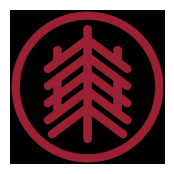

In [13]:
wm = T(wm)
wm = wm.cuda()
pltshow(wm)

In [14]:
alpha = 0.05
block_size = 4

In [15]:
img = T(img).cuda()

In [16]:
wmed = embed_wm(img,wm,alpha,block_size)

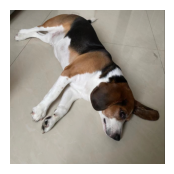

In [17]:
pltshow(wmed)

In [18]:
extract = extract_wm(img,wmed,alpha,block_size)

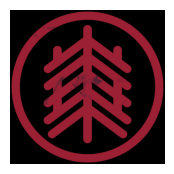

In [19]:
pltshow(extract)

In [20]:
beta = 8/255
pgd_atk = torchattacks.PGD(model, eps=8/255, alpha=beta, steps=10, random_start=True)
wmed_input = torch.unsqueeze(wmed,0).type(torch.FloatTensor)
target = torch.tensor([162]).cuda()
adv_images = pgd_atk(wmed_input, target)
out_per = (F.softmax(model(adv_images),dim=1))
print(torch.max(out_per))
print(out_per.argmax())
pgd_wmed = adv_images[0,...]

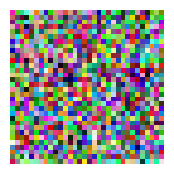

In [ ]:
pltshow(extract_wm(img,pgd_wmed,alpha,block_size))

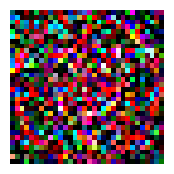

In [ ]:
pgd_per = (pgd_wmed-wmed)/beta
per_dct = dct_tensor(pgd_per)
wm_per = per_dct * (beta/alpha)
wm_perturbed = (wm_per+wm).clip(0,1)
pltshow(wm_perturbed)

In [ ]:
wmed_new = embed_wm(img,wm_perturbed,alpha,block_size)

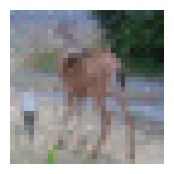

In [ ]:
pltshow(wmed_new)

In [ ]:
new_input = torch.unsqueeze(wmed_new,0).type(torch.cuda.FloatTensor)
out_per = (F.softmax(model(new_input),dim=1))
print(torch.max(out_per))
print(out_per.argmax())

tensor(0.9842, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4, device='cuda:0')
